# Prerequisities

Install FrEIA dependency

In [1]:
pip install git+https://github.com/VLL-HD/FrEIA.git

  Cloning https://github.com/VLL-HD/FrEIA.git to /tmp/pip-req-build-qyc9rjy8
  Running command git clone -q https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-qyc9rjy8
  Using cached scipy-1.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
  Created wheel for FrEIA: filename=FrEIA-0.2-py3-none-any.whl size=42766 sha256=465ab06d0ec7205eb344c0e6711dbd256cb1abcfe57b07b07840abd85209e04c
  Stored in directory: /tmp/pip-ephem-wheel-cache-k1js6h5o/wheels/4e/93/66/7d155f3e489f4989497efd95f5282be112aa21b4c4f42b69e5
Successfully built FrEIA
You should consider upgrading via the '/home/dkalsan/.virtualenvs/3dcv-tmp/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Import dependent packages

In [1]:
from collections import defaultdict
import time

import numpy as np

from pathlib import Path

import torch
import torch.optim
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data       import Dataset, DataLoader, random_split
from torch.distributions    import MultivariateNormal
from torchvision.datasets   import FashionMNIST

from matplotlib import pyplot as plt
from matplotlib import patches as plot_patches

import FrEIA.framework as Ff
import FrEIA.modules as Fm

# 1 - Toy Example Demo

data.py

In [2]:
markers = ['o', 's', '^'] # circle, square, triangle
colors = ['red', 'green', 'blue', 'pink', 'black', 'purple']

class GaussianDistributions(Dataset):

    def __init__(self, nr_samples, distribution_centers, style=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.nr_samples = nr_samples
        self.nr_distributions = len(distribution_centers)

        # Create a distribution for each given center point
        distributions = [MultivariateNormal(torch.tensor(center), torch.eye(len(center))) for center in distribution_centers]
        
        # Create samples and labels for each distribution
        self.data = []
        shapes = torch.tensor([0,1,2])

        for label, distribution in enumerate(distributions):
            for i in range(nr_samples):
                sample = distribution.sample()

                if style:
                    shape = torch.randint(low=0, high=len(shapes), size=(1,))
                    sample = torch.cat((sample, shape))
                self.data.append((sample, label))
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data[idx]

        return sample

def plot_distributions(data):
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    ax.grid(True)

    # Only plot datapoints
    if len(data[0]) == 2:
        x1,y1 = data.T
        ax.scatter(x1,y1, s=plt.rcParams['lines.markersize'])

    # Plot datapoints, color by labelling
    elif len(data[0]) == 3:
        legend_handles = []

        # group data by label
        label_dict = defaultdict(list)
        for x, y, label in data:
            label_dict[label].append([x,y])
        
        # plot with color by label
        for label, datapoints in label_dict.items():
            legend_handles.append(plot_patches.Patch(color=colors[int(label)], label=f'label {int(label)}'))

            x1,y1 = np.array(datapoints).T
            ax.scatter(x1,y1, s=plt.rcParams['lines.markersize'], label=f'label {int(label)}', color=colors[int(label)]) 
       
        ax.legend(handles=legend_handles)

    # Plot datapoints, color & shape
    elif len(data[0]) == 4:
        invalid_shape_count = 0
        legend_handles = []

        # group data by label
        label_dict = defaultdict(list)
        for x, y, shape, label in data:
            label_dict[label].append([x,y, shape])
        
        for label, group in label_dict.items():
            legend_handles.append(plot_patches.Patch(color=colors[int(label)], label=f'label {int(label)}'))

            # group data by shape
            shape_dict = defaultdict(list)
            for x, y, shape in group:
                s = round(shape)
                if s < 0 or s > 2:
                    invalid_shape_count += 1
                    continue
                shape_dict[s].append([x,y])

            for shape, datapoints in shape_dict.items():
                # plot with color by label and shape
                x1,y1 = np.array(datapoints).T
                ax.scatter(x1,y1, s=plt.rcParams['lines.markersize'], label=f'label {int(label)}', marker=markers[shape], color=colors[int(label)])
       
        ax.legend(handles=legend_handles)
        print(f"Shape class invalid: {str(invalid_shape_count)} of {len(data)}")

    plt.show()

model.py

In [3]:
def one_hot_sequenceINN(labels, nr_conditions, out=None):
    '''
    Framework is currently bugged. For SequenceINN, this needs to be passed as a tuple.
    '''

    out = one_hot_GraphINN(labels, nr_conditions, out)
    return (out,)

"""
Function from: https://github.com/VLL-HD/conditional_INNs/blob/master/mnist_minimal_example
"""
def one_hot_GraphINN(labels, nr_conditions, out=None):
    '''
    Convert LongTensor labels (contains labels 0-9), to a one hot vector.
    Can be done in-place using the out-argument (faster, re-use of GPU memory)
    '''
    if out is None:
        out = torch.zeros(labels.shape[0], nr_conditions).to(labels.device)
    else:
        out.zeros_()

    out.scatter_(dim=1, index=labels.view(-1,1), value=1.)
    return out

"""
Function adapted from: https://github.com/VLL-HD/conditional_INNs/blob/master/mnist_minimal_example
"""
class Toy_cINN(nn.Module):
    '''cINN for class-conditional MNISt generation'''
    def __init__(self, dims, nr_conditions):
        super().__init__()

        self.cinn = self.build_inn(dims, nr_conditions)
        self.dims = dims
        self.nr_conditions = nr_conditions

    def build_inn(self, dims, nr_conditions):
        cond_shape = (nr_conditions,)

        def subnet_fc(c_in, c_out):
            return nn.Sequential(nn.Linear(c_in, 256), nn.ReLU(),
                                nn.Linear(256,  256), nn.ReLU(),
                                nn.Linear(256,  c_out))

        inn = Ff.SequenceINN(dims)

        for _ in range(8):
            inn.append(Fm.AllInOneBlock, cond=0, cond_shape=cond_shape, subnet_constructor=subnet_fc, permute_soft=False)

        return inn

    def forward(self, x, l, jac=True):
        z, jac = self.cinn(x, c=one_hot_sequenceINN(l, self.nr_conditions), jac=jac)
        return z, jac

    def reverse_sample(self, z, l):
        return self.cinn(z, c=one_hot_sequenceINN(l, self.nr_conditions), rev=True)


train.py

In [4]:
"""
Adapted from: https://github.com/VLL-HD/conditional_INNs/blob/master/mnist_minimal_example
"""
def train(inn, train_loader, test_loader, learning_rate, weight_decay, gamma, epochs):
    inn.cuda()

    trainable_parameters = [p for p in inn.parameters() if p.requires_grad]

    optimizer = torch.optim.Adam(trainable_parameters, lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i for i in range(0,epochs,10)], gamma=gamma)

    val_x, val_l = zip(*list(sample for sample in test_loader.dataset))
    val_x = torch.stack(val_x, 0).cuda()
    val_l = torch.LongTensor(val_l).cuda()

    t_start = time.time()
    nll_list = []
    print('Epoch\tBatch/Total \tTime \tNLL train\tNLL val\t\tLR')
    for epoch in range(epochs):
        for batch, (x, l) in enumerate(train_loader):
            x, l = x.cuda(), l.cuda()

            z, log_j = inn(x, l)

            nll = torch.mean(z**2) / 2 - torch.mean(log_j) / inn.dims
            nll.backward()
            torch.nn.utils.clip_grad_norm_(trainable_parameters, 10.)
            nll_list.append(nll.item())
            optimizer.step()
            optimizer.zero_grad()

            if not batch % 50:
                curr_lr = optimizer.param_groups[0]['lr']
                print_training_progress(inn, val_x, val_l, t_start, epoch, batch, len(train_loader), np.mean(nll_list), curr_lr)
                nll_list = []
        scheduler.step()

    return inn

def print_training_progress(inn, testdata_x, testdata_l, t_start, epoch, batch, nr_batches, nll_mean, curr_lr):
    with torch.no_grad():
        z, log_j = inn(testdata_x, testdata_l)
        nll_val = torch.mean(z**2) / 2 - torch.mean(log_j) / inn.dims

    print('%.3i \t%.5i/%.5i \t%.2f \t%.6f\t%.6f\t%.2e' % (epoch,
                                                    batch, nr_batches,
                                                    (time.time() - t_start)/60.,
                                                    nll_mean,
                                                    nll_val.item(),
                                                    curr_lr,
                                                    ), flush=True)

toy.py

In [5]:
# hyper parameters
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
EPOCHS = 60
LEARNING_RATE = 1e-2 # 1.0
WEIGHT_DECAY=1e-5
GAMMA = 0.5
LOG_INTERVAL = 50

def test_2d(inn, test_loader):
    inn.cuda()

    #Plot initial distributions
    input_data = np.array([np.append(x.cpu().detach().numpy(), label) for x, label in test_loader.dataset])

    print("----- Initial Distributions -----")
    plot_distributions(input_data)

    #Plot mapping
    results = []
    with torch.no_grad():
        for x, l in test_loader:
            x = x.cuda()
            l = l.cuda()
        
            output, log_j = inn(x, l, jac=False)
            results += torch.hstack((output,torch.unsqueeze(l, dim=1)))

    results = np.array([x.cpu().detach().numpy() for x in results])

    print("----- Latent Space -----")
    plot_distributions(results)

    # Plot reverse samples
    results = []
    center_dist = GaussianDistributions(nr_samples=200, distribution_centers=[[0.0, 0.0]]*test_loader.dataset.nr_distributions)
    rev_loader  = DataLoader(center_dist, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for z, l in rev_loader:
            z = z.cuda()
            l = l.cuda()
        
            output, log_j = inn.reverse_sample(z, l)

            # Append labels to output and add to result
            results += torch.hstack((output,torch.unsqueeze(l, dim=1)))

    # From torch to numpy for plotting
    results = np.array([x.cpu().detach().numpy() for x in results])

    print("----- Sample Generation -----")
    plot_distributions(results)
    return

def style_transfer(inn, test_loader):
    inn.cuda()

    ###### Plot with shapes
    #Plot initial distributions
    input_data = np.array([np.append(x.cpu().detach().numpy(), label) for x, label in test_loader.dataset])

    print("----- Initial Distributions -----")
    plot_distributions(input_data)

    ######## style transfer
    # labels 0,..., label_count-1 will be present
    label_count = test_loader.dataset.nr_distributions
    sample_size = 5

    # as long as sample_size is low, labels will by consruction be 0
    x, l = zip(*test_loader.dataset[:sample_size])
    x = torch.stack(list(x))
    l = torch.tensor(list(l))

    # get latent vector z for samples
    with torch.no_grad():
        x = x.cuda()
        l = l.cuda()
    
        z, _ = inn(x, l, jac=False)

    # Transfer style
    results = []
    with torch.no_grad():
        for l in range(label_count):
            z = z.cuda()
            l = torch.tensor([l]*sample_size).cuda()
        
            output, _ = inn.reverse_sample(z, l)

            # Append labels to output and add to result
            results += torch.hstack((output,torch.unsqueeze(l, dim=1)))

    # From torch to numpy for plotting
    results = np.array([x.cpu().detach().numpy() for x in results])


    print("----- Style Transfer-----")
    plot_distributions(results)

    ####### Fix one dim to shape triangle in latent space and reverse_sample
    # dimension 1 of latent space seems to encode shape information most often.
    # Not consistently replicateable, however
    results = []
    center_dist = GaussianDistributions(nr_samples=50, distribution_centers=[[0.0, 0.0]]*test_loader.dataset.nr_distributions)
    rev_loader  = DataLoader(center_dist, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for z, l in rev_loader:
            
            shape_tensor = torch.full(size=(z.shape[0],1), fill_value=2.0)
            # fix dim 0
            #z = torch.hstack((shape_tensor, z))

            # fix dim 1
            d0, d2 = torch.split(z, 1, dim=1)
            z = torch.hstack((d0, shape_tensor, d2))

            # fix dim 2
            #z = torch.hstack((z, shape_tensor))

            z = z.cuda()
            l = l.cuda()
        
            output, log_j = inn.reverse_sample(z, l)

            # Append labels to output and add to result
            results += torch.hstack((output,torch.unsqueeze(l, dim=1)))

    # From torch to numpy for plotting
    results = np.array([x.cpu().detach().numpy() for x in results])

    print("----- Sample Generation - Latent Dimension 2 fixed to 2.0 -----")
    plot_distributions(results)
    return

def no_style(distribution_centers):
    inn = Toy_cINN(dims=2, nr_conditions=len(distribution_centers))

    train_data  = GaussianDistributions(nr_samples=800, distribution_centers=distribution_centers)
    test_data   = GaussianDistributions(nr_samples=400, distribution_centers=distribution_centers)

    train_loader    = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader     = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    inn = train(inn, train_loader, test_loader, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, gamma=GAMMA)

    test_2d(inn, test_loader)

def with_style(distribution_centers):
    inn = Toy_cINN(dims=3, nr_conditions=len(distribution_centers))

    train_data  = GaussianDistributions(nr_samples=800, distribution_centers=distribution_centers, style=True)
    test_data   = GaussianDistributions(nr_samples=400, distribution_centers=distribution_centers, style=True)

    train_loader    = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader     = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    inn = train(inn, train_loader, test_loader, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, gamma=GAMMA)

    style_transfer(inn, test_loader)

## 1.1 - Sample Generation

######################################
Training network for Sample Generation
######################################
Epoch	Batch/Total 	Time 	NLL train	NLL val		LR
000 	00000/00050 	0.01 	33.195744	12.351091	5.00e-03
001 	00000/00050 	0.03 	2.358625	0.893390	5.00e-03
002 	00000/00050 	0.05 	0.778048	0.646803	5.00e-03
003 	00000/00050 	0.08 	0.704177	0.611459	5.00e-03
004 	00000/00050 	0.10 	0.743027	1.017971	5.00e-03
005 	00000/00050 	0.12 	0.655118	0.651544	5.00e-03
006 	00000/00050 	0.16 	0.617653	0.551180	5.00e-03
007 	00000/00050 	0.18 	0.597841	0.595686	5.00e-03
008 	00000/00050 	0.21 	0.595246	0.635370	5.00e-03
009 	00000/00050 	0.23 	0.583513	0.563757	5.00e-03
010 	00000/00050 	0.25 	0.576479	0.578634	2.50e-03
011 	00000/00050 	0.28 	0.534461	0.547284	2.50e-03
012 	00000/00050 	0.31 	0.543007	0.532772	2.50e-03
013 	00000/00050 	0.35 	0.545997	0.536563	2.50e-03
014 	00000/00050 	0.37 	0.543323	0.607916	2.50e-03
015 	00000/00050 	0.41 	0.539200	0.552104	2.50e-03
016 	00000/00050 	

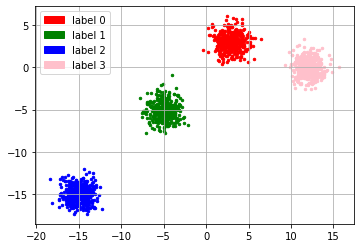

----- Latent Space -----


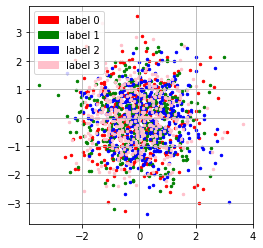

----- Sample Generation -----


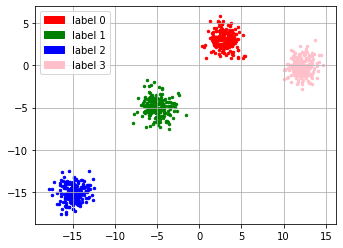

In [6]:
distribution_centers = [[3.0,3.0], [-5.0,-5.0], [-15.0,-15.0], [12.0, 0.0]]

print("######################################")
print("Training network for Sample Generation")
print("######################################")
no_style(distribution_centers)

## 1.2 - Style Transfer

#####################################
Training network for Style Transfer
#####################################
Epoch	Batch/Total 	Time 	NLL train	NLL val		LR
000 	00000/00050 	0.00 	29.050333	14.277765	5.00e-03
001 	00000/00050 	0.02 	1.916611	0.992206	5.00e-03
002 	00000/00050 	0.04 	0.756260	0.636790	5.00e-03
003 	00000/00050 	0.06 	0.651421	0.649067	5.00e-03
004 	00000/00050 	0.08 	0.573165	0.549972	5.00e-03
005 	00000/00050 	0.11 	0.577353	0.568493	5.00e-03
006 	00000/00050 	0.13 	0.503135	0.523781	5.00e-03
007 	00000/00050 	0.15 	0.541137	0.473480	5.00e-03
008 	00000/00050 	0.18 	0.513931	0.447251	5.00e-03
009 	00000/00050 	0.20 	0.493566	0.504402	5.00e-03
010 	00000/00050 	0.23 	0.458822	0.408815	2.50e-03
011 	00000/00050 	0.25 	0.397366	0.356637	2.50e-03
012 	00000/00050 	0.28 	0.386921	0.365480	2.50e-03
013 	00000/00050 	0.30 	0.329291	0.268542	2.50e-03
014 	00000/00050 	0.33 	0.264051	0.236116	2.50e-03
015 	00000/00050 	0.37 	0.273706	0.262989	2.50e-03
016 	00000/00050 	0.39 

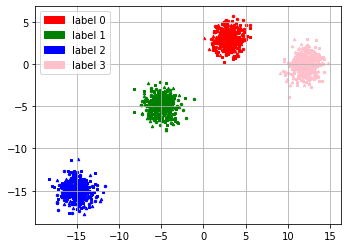

----- Style Transfer-----
Shape class invalid: 0 of 20


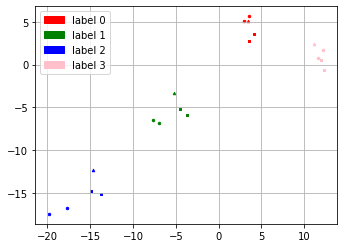

----- Sample Generation - Latent Dimension 2 fixed to 2.0 -----
Shape class invalid: 0 of 200


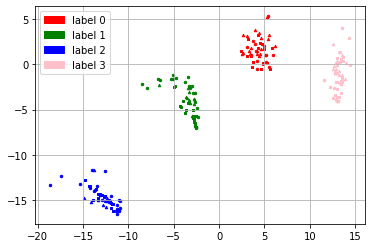

In [7]:
distribution_centers = [[3.0,3.0], [-5.0,-5.0], [-15.0,-15.0], [12.0, 0.0]]

print("#####################################")
print("Training network for Style Transfer")
print("#####################################")
with_style(distribution_centers)

# 2 - Application to FashionMNIST Demo

configuration

In [48]:
# Set to True if you'd like to perform network training.
# Note that the training takes approximately 2 hours
# on Google Colab.
perform_training = False

# Configuration for the model training
# NOTE: lr=1e-3 can sometimes blow up in the very beggining, 
#       depending on weight initialization. However reducing
#       it to 1e-4 resulted in worse generated sample 
#       quality during our experiments.
config = {
    "batch_size": 256,
    "seed": 42,
    "device": "cuda",  # "cuda" or "cpu"

    "data": {
        "augm_sigma": 0.02,
        "val_percentage": 0.05
    },

    "train": {
        "n_epochs": 15,
        "lr": 1e-3,

        "scheduler": {
            "milestones": [20, 40],
            "gamma": 0.1
        }
    }
}

<h4 style="color:red">If you would like to use the pretrained model, you can download it <a href="https://drive.google.com/file/d/195kSVcEenGdLJQBbpPmigfUhOYb8J2e8/view?usp=sharing">here</a> then store it in the same directory as this notebook.</h4>

data.py

In [49]:
DATA_MEAN = 0.2861
DATA_STD = 0.3530

LABEL_NAMES = {
    0: "t_shirt_or_top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle_boot"
}

# NOTE: We duplicate the grayscale channel
IM_DIMS = (2, 28, 28)
NDIMS_TOTAL = np.prod(IM_DIMS)


def unnormalize(x):
    return x * DATA_STD + DATA_MEAN


def get_trainval_datasets(config):

    n_eval = int(config["val_percentage"] * 60000)
    n_train = 60000 - n_eval

    trainval_ds = FashionMNIST(Path("FashionMNIST/FashionMNIST/data"),
                               train=True,
                               download=True,
                               transform=T.Compose([T.ToTensor(),
                                                    T.Normalize(DATA_MEAN, DATA_STD),
                                                    T.Lambda(lambda x: x.repeat(2, 1, 1))]))

    train_ds, val_ds = random_split(trainval_ds,
                                    [n_train, n_eval],
                                    generator=torch.Generator().manual_seed(config["seed"]))

    # Additionally add noise to train transform to stabilize training
    train_ds.dataset.transform = T.Compose([train_ds.dataset.transform,
                                            T.Lambda(lambda x: x + config["augm_sigma"] * torch.randn_like(x))])

    return train_ds, val_ds


def get_test_dataset():
    test_ds = FashionMNIST(Path("FashionMNIST/FashionMNIST/data"),
                           train=False,
                           download=True,
                           transform=T.Compose([
                               T.ToTensor(),
                               T.Normalize(DATA_MEAN, DATA_STD),
                               T.Lambda(lambda x: x.repeat(2, 1, 1))
                           ]))

    return test_ds


def get_dataloader(ds, config):
    pin_memory = True if config["device"] == "cuda" else False
    return DataLoader(ds,
                      batch_size=config["batch_size"],
                      shuffle=True,
                      num_workers=2,
                      pin_memory=pin_memory,
                      drop_last=True)


model.py

In [50]:
"""
Code adapted from: https://github.com/VLL-HD/conditional_INNs/blob/master/mnist_minimal_example/model.py
"""


def one_hot_encode(y):
    """
    We create one-hot-encodings for 4 stages:
    Stage 1: (N, 1, 28, 28), where N is the length of y array
             and the feature map at index i is full of values
             y[i] + 1 / 10. We assume 10 possible class values
             of FashionMNIST from 0 to 9.
    Stage 2: (N, 1, 14, 14), analogous to stage 1
    Stage 3: (N, 1, 7, 7), analogous to stage 1
    Stage 4: (N, 10), a generic OHC, where the vector at index i
                      has all elements equals to 0, except for
                      the index at position y[i].
    """

    out_stage1 = y.reshape(-1, 1, 1, 1).repeat(1, 1, 28, 28).to(y.device)
    out_stage1 = ((out_stage1 + 1) / 10).float()

    out_stage2 = y.reshape(-1, 1, 1, 1).repeat(1, 1, 14, 14).to(y.device)
    out_stage2 = ((out_stage2 + 1) / 10).float()

    out_stage3 = y.reshape(-1, 1, 1, 1).repeat(1, 1, 7, 7).to(y.device)
    out_stage3 = ((out_stage3 + 1) / 10).float()

    out_stage4 = torch.zeros(y.shape[0], 10).to(y.device)
    out_stage4.scatter_(dim=1, index=y.view(-1, 1), value=1.)

    return [out_stage1, out_stage2, out_stage3, out_stage4]


class FashionMNIST_cINN(nn.Module):

    def __init__(self, lr):
        super().__init__()

        self.cinn = self.build_inn()

        self.trainable_parameters = [p for p in self.cinn.parameters() if p.requires_grad]
        for p in self.trainable_parameters:
            p.data = 0.01 * torch.randn_like(p)

        self.optimizer = torch.optim.Adam(self.trainable_parameters, lr=lr, weight_decay=1e-5)

    def build_inn(self):

        def sub_conv(ch_hidden, kernel):
            pad = kernel // 2
            return lambda ch_in, ch_out: nn.Sequential(
                                            nn.Conv2d(ch_in, ch_hidden, kernel, padding=pad),
                                            nn.ReLU(),
                                            nn.Conv2d(ch_hidden, ch_out, kernel, padding=pad))

        def sub_fc(ch_hidden):
            return lambda ch_in, ch_out: nn.Sequential(
                                            nn.Linear(ch_in, ch_hidden),
                                            nn.ReLU(),
                                            nn.Linear(ch_hidden, ch_out))

        conditions = [Ff.ConditionNode(1, 28, 28),
                      Ff.ConditionNode(1, 14, 14),
                      Ff.ConditionNode(1, 7, 7),
                      Ff.ConditionNode(10)]

        nodes = [Ff.InputNode(*IM_DIMS)]

        split_nodes = []

        # Stage 1
        subnet = sub_conv(32, 3)
        for k in range(5):
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {"seed": k}))
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {"subnet_constructor": subnet, "clamp": 1.0},
                                 conditions=conditions[0]))

        nodes.append(Ff.Node(nodes[-1], Fm.Split,
                             {"section_sizes": [1, 1], "dim": 0}))
        split_nodes.append(Ff.Node(nodes[-1].out1, Fm.Flatten, {}))

        nodes.append(Ff.Node(nodes[-1].out0, Fm.HaarDownsampling, {"rebalance": 0.5}))

        # Stage 2
        subnet = sub_conv(64, 3)
        for k in range(5):
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {"seed": k}))
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {"subnet_constructor": subnet, "clamp": 1.0},
                                 conditions=conditions[1]))

        nodes.append(Ff.Node(nodes[-1], Fm.Split,
                             {"section_sizes": [2, 2], "dim": 0}))
        split_nodes.append(Ff.Node(nodes[-1].out1, Fm.Flatten, {}))

        nodes.append(Ff.Node(nodes[-1].out0, Fm.HaarDownsampling, {"rebalance": 0.5}))

        # Stage 3
        subnet = sub_conv(128, 3)
        for k in range(10):
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {"seed": k}))
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {"subnet_constructor": subnet, "clamp": 1.0},
                                 conditions=conditions[2]))

        nodes.append(Ff.Node(nodes[-1], Fm.Split,
                             {"section_sizes": [4, 4], "dim": 0}))
        split_nodes.append(Ff.Node(nodes[-1].out1, Fm.Flatten, {}))
        nodes.append(Ff.Node(nodes[-1].out0, Fm.Flatten, {}))

        # Stage 4
        subnet = sub_fc(512)
        for k in range(15):
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {"seed": k}))
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {"subnet_constructor": subnet, "clamp": 1.0},
                                 conditions=conditions[3]))

        nodes.append(Ff.Node([s.out0 for s in split_nodes] + [nodes[-1].out0],
                             Fm.Concat, {"dim": 0}))
        nodes.append(Ff.OutputNode(nodes[-1]))

        return Ff.ReversibleGraphNet(nodes + split_nodes + conditions, verbose=False)

    def forward(self, x, y):
        z, jac = self.cinn(x, c=one_hot_encode(y))
        return z, jac

    def reverse_sample(self, z, y):
        return self.cinn(z, c=one_hot_encode(y), rev=True)

utils.py

In [51]:
def parse_config(config, field, extra_fields):
    assert field in config.keys(), f"Missing field {field} in config.json."
    parsed_config = config[field]

    for extra_field in extra_fields:
        assert extra_field in list(config.keys()), f"Missing extra field {extra_field} in config.json"
        parsed_config[extra_field] = config[extra_field]

    return parsed_config

train.py (adapted for notebook compatibility)

In [52]:
def train_fashionmnist(config):

    """
    Prepare data
    """

    data_config = parse_config(config, "data", ["seed", "batch_size", "device"])
    train_ds, val_ds = get_trainval_datasets(data_config)
    train_dl = get_dataloader(train_ds, data_config)
    val_dl = get_dataloader(val_ds, data_config)

    """
    Prepare model
    """

    train_config = parse_config(config, "train", ["seed", "batch_size", "device"])
    cinn = FashionMNIST_cINN(train_config["lr"])
    cinn.to(train_config["device"])
    scheduler = torch.optim.lr_scheduler.MultiStepLR(cinn.optimizer, **train_config["scheduler"])

    """
    Perform training

    Code adapted from: https://github.com/VLL-HD/conditional_INNs/blob/master/mnist_minimal_example/train.py
    """

    t_start = time.time()
    nll_mean = []

    print("Epoch\tBatch/Total\tTime\tNLL train\tNLL val\tLR")
    for epoch in range(train_config["n_epochs"]):
        for i, (x, y) in enumerate(train_dl):

            x, y = x.to(train_config["device"]), y.to(train_config["device"])
            z, log_j = cinn(x, y)

            nll = torch.mean(z**2) / 2 - torch.mean(log_j) / NDIMS_TOTAL
            nll.backward()
            torch.nn.utils.clip_grad_norm_(cinn.trainable_parameters, 10.)
            nll_mean.append(nll.item())
            cinn.optimizer.step()
            cinn.optimizer.zero_grad()

            if not i % 50:
                with torch.no_grad():

                    nll_val_mean = []
                    for (x_val, y_val) in val_dl:
                        x_val, y_val = x_val.to(train_config["device"]), y_val.to(train_config["device"])
                        z, log_j = cinn(x_val, y_val)
                        nll_val = torch.mean(z**2) / 2 - torch.mean(log_j) / NDIMS_TOTAL
                        nll_val_mean.append(nll_val.item())

                print("%.3i\t%.5i/%.5i\t%.2f\t%.6f\t%.6f\t%.2e" % (epoch,
                                                                   i, len(train_dl),
                                                                   (time.time() - t_start)/60.,
                                                                   np.mean(nll_mean),
                                                                   np.mean(nll_val_mean),
                                                                   cinn.optimizer.param_groups[0]["lr"],
                                                                   ), flush=True)
                nll_mean = []

        # Show 10 generated images per class every 10th epoch
        if not epoch % 10:
            y = torch.arange(0, 10).repeat_interleave(10).to(train_config["device"])
            z = z = 1.0 * torch.randn(100, NDIMS_TOTAL).to(train_config["device"])

            with torch.no_grad():
                samples = cinn.reverse_sample(z, y)[0].cpu().numpy()
                samples = unnormalize(samples)
                if IM_DIMS[0] > 1:
                    samples = samples.mean(axis=1)

            full_image = np.zeros((28*10, 28*10))

            for k in range(100):
                i, j = k // 10, k % 10
                full_image[28*i:28*(i+1), 28*j:28*(j+1)] = samples[k]

            full_image = np.clip(full_image, 0, 1)
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Generated samples")
            plt.imshow(full_image, vmin=0, vmax=1, cmap="gray")
            plt.show()

        scheduler.step()

    torch.save(cinn.state_dict(), 'fashionmnist_cinn.pt')

sampling

In [53]:
def sample(model, config):
    y = torch.arange(0, 10).repeat_interleave(10).to(config["device"])
    z = z = 1.0 * torch.randn(100, NDIMS_TOTAL).to(config["device"])

    with torch.no_grad():
        samples = cinn.reverse_sample(z, y)[0].cpu().numpy()
        samples = unnormalize(samples)
        if IM_DIMS[0] > 1:
            samples = samples.mean(axis=1)

    full_image = np.zeros((28*10, 28*10))

    for k in range(100):
        i, j = k // 10, k % 10
        full_image[28*i:28*(i+1), 28*j:28*(j+1)] = samples[k]

    full_image = np.clip(full_image, 0, 1)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Generated samples")
    plt.imshow(full_image, vmin=0, vmax=1, cmap="gray")
    plt.show()

## 2.1 - Sample generation

<p style="color: red">Note that often the model initialization fails stating that weights are missing in the .pt file. This is why we try the model loading 1000 times (usually it takes about 5 rounds to get it right). For some unknown reason, the last Flatten layers from skip connections initialize in wrong order. This bug happens quite often, usually it takes us 5 re-runs of the cell before success.</p>

In [54]:
if perform_training == True:
    train_fashionmnist(config)

assert Path("fashionmnist_cinn.pt").exists(), "Please train the model or download the pretrained one" \
                                              " from the GDrive link provided at the start of the" \
                                              " FashionMNIST section in red letters."

In [55]:
for i in range(1000):
    try:
        cinn = FashionMNIST_cINN(0)
        cinn.to(config["device"])
        state_dict = {k: v for k, v in torch.load('fashionmnist_cinn.pt').items() if 'tmp_var' not in k}
        cinn.load_state_dict(state_dict)
        cinn.eval()
    except Exception:
        pass
    else:
        print("Model successfully loaded")
        break

Model successfully loaded


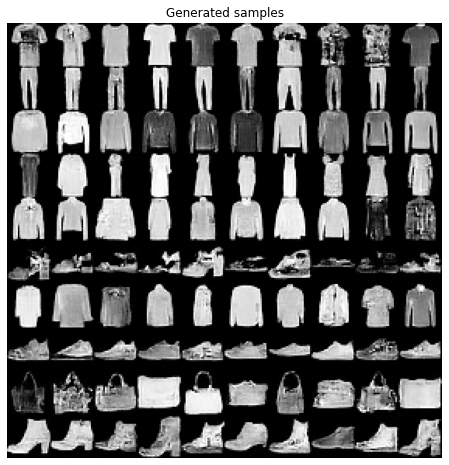

In [58]:
sample(cinn, config)

The generated samples from top to bottom are:
* T-Shirt/Top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

## 2.2 - Style Transfer